## AB testing access time for ICESat-2 HDF5 files on the cloud.

This notebook requires that we have 2 versions of the same file:
  * Original A: The original file with no modifications on a S3 location.
  * Test Case B: A modified version of the orignal file to test for metadata consolidation, rechunking and other strategies to speed up access to the data in the file.


In [1]:
import xarray as xr
import h5py
import fsspec
import logging
import re
import time
import pandas as pd


class RegexFilter(logging.Filter):
    def __init__(self, regex_pattern):
        super(RegexFilter, self).__init__()
        self.regex_pattern = re.compile(regex_pattern)

    def filter(self, record):
        # Apply the regex pattern to the log message
        return not bool(self.regex_pattern.search(record.msg))


logger = logging.getLogger('fsspec')
logger.setLevel(logging.DEBUG)

regex_pattern = r'<File-like object S3FileSystem, .*?>\s*(read: \d+ - \d+)'
regex_filter = RegexFilter(regex_pattern)
logging.getLogger().addFilter(regex_filter)

In [2]:
for library in (xr, h5py, fsspec):
    print(f'{library.__name__} v{library.__version__}')

xarray v2023.12.0
h5py v3.9.0
fsspec v2023.6.0


In [3]:
# This will use the embedded credentials in the hub to access the s3://nasa-cryo-persistent bucket
fs = fsspec.filesystem('s3')


test_dict = {
    "ATL08": {
        "links": {
            "original": "s3://nasa-cryo-persistent/h5cloud/atl08/original/ATL08_20200404075919_01340707_006_03.h5",
            "optimized": "s3://nasa-cryo-persistent/h5cloud/atl08/repacked/ATL08_20200404075919_01340707_006_03_repacked.h5",
        },
        "group": "/gt1l/signal_photons",
        "variable": "ph_h",
        "processing": [
            "h5repack -S PAGE -G 4000000"
        ]
    },
    "ATL03": {
        "links": {
            "original": "s3://nasa-cryo-persistent/h5cloud/atl03/average/original/ATL03_20230618223036_13681901_006_01.h5",
            "optimized": "s3://nasa-cryo-persistent/h5cloud/atl03/average/repacked/ATL03_20230618223036_13681901_006_01.h5"
        },
        "group": "/gt1l/heights",
        "variable": "h_ph",
        "processing": [
            "h5repack -S PAGE -G 4000000"
        ]
    },
    "ATL03-BIG": {
        "links": {
            "original": "s3://nasa-cryo-persistent/h5cloud/atl03/big/original/ATL03_20181120182818_08110112_006_02.h5",
            "optimized": "s3://nasa-cryo-persistent/h5cloud/atl03/big/repacked/ATL03_20181120182818_08110112_006_02_repacked.h5",
        },
        "group": "/gt1l/heights",
        "variable": "h_ph",
        "processing": [
            "h5repack -S PAGE -G 4000000"
        ]
    },
    "ATL03-MED": {
        "links": {
            "original": "s3://nasa-cryo-persistent/h5cloud/atl03/big/original/ATL03_20210402143840_01341107_006_02.h5",
            "optimized": "s3://nasa-cryo-persistent/h5cloud/atl03/big/repacked/ATL03_20210402143840_01341107_006_02_repacked.h5",
        },
        "group": "/gt1l/heights",
        "variable": "h_ph",
        "processing": [
            "h5repack -S PAGE -G 4000000"
        ]
    }
}

### The following code needs to be migrated to the test suit undet h5test.

In [4]:
%%capture

benchmarks = []

for key, dataset in test_dict.items():
    for k, link in dataset["links"].items():
        print (key, link, k, dataset["group"])
        try:
            log_filename = f"logs/fsspec-xarray-{key}-{k}-readahead.log"
            
            # Create a new FileHandler for each iteration
            file_handler = logging.FileHandler(log_filename)
            file_handler.setLevel(logging.DEBUG)

            # Add the handler to the root logger
            logging.getLogger().addHandler(file_handler)

            # Test the logger with some log messages
            with fs.open(link, mode='rb') as file:


                start = time.time()
                ds = xr.open_dataset(file, group=dataset["group"], engine="h5netcdf", decode_cf=False)
                data_mean = ds[dataset["variable"]].mean()
                elapsed = time.time() - start
                benchmarks.append({"tool": "xarray",
                                   "dataset": key,
                                   "format": k,
                                   "file": link,
                                   "time": elapsed,
                                   "mean": data_mean})
            
            logging.getLogger().removeHandler(file_handler)
            logging.getLogger().removeFilter(regex_filter)
            file_handler.close()
            
            

        except Exception as e:
            print(e)
            
for key, dataset in test_dict.items():
    for k, link in dataset["links"].items():
        print (key, link, k, dataset["group"])
        try:
            log_filename = f"logs/fsspec-h5py-{key}-{k}.log"
            
            # Create a new FileHandler for each iteration
            file_handler = logging.FileHandler(log_filename)
            file_handler.setLevel(logging.DEBUG)

            # Add the handler to the root logger
            logging.getLogger().addHandler(file_handler)
            logging.getLogger().addFilter(regex_filter)
            # this is mostly IO so no perf_counter is needed
            start = time.time()
            with h5py.File(fs.open(link, mode="rb")) as f:
                path = f"{dataset['group']}/{dataset['variable']}"
                data = f[path][:]
                data_mean = data.mean()
                elapsed = time.time() - start
                benchmarks.append({"tool": "h5py",
                                   "dataset": key,
                                   "format": k,
                                   "file": link,
                                   "time": elapsed,
                                   "mean": data_mean})


                logging.getLogger().removeHandler(file_handler)      
                file_handler.close()
            

        except Exception as e:
            print(e)

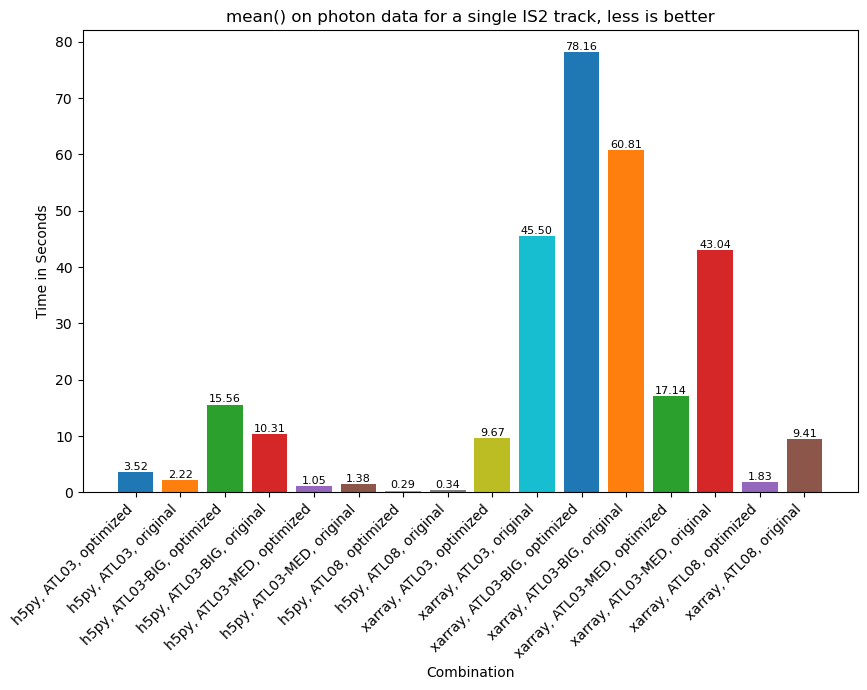

In [5]:
import matplotlib.pyplot as plt

df = pd.DataFrame.from_dict(benchmarks)

fig, ax = plt.subplots(figsize=(10, 6))

for name, group in df.groupby(['tool', 'dataset', 'format']):
    tool, dataset, formated = name
    x = f'{tool}, {dataset}, {formated}'
    y = group['time'].mean()
    ax.bar(f'{tool}, {dataset}, {formated}', group['time'].mean(), label=f'{tool}, {dataset}, {formated}', align='center')
    ax.text(x, y + 0.05, f'{group["time"].mean():.2f}', ha='center', va='bottom', color='black', fontsize=8)

# Set labels and title
ax.set_xlabel('Combination')
ax.set_ylabel('Time in Seconds')
ax.set_title('mean() on photon data for a single IS2 track, less is better')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# # Show legend
# ax.legend()

# Show the plot
plt.show()


In [ ]:
# def normalize_log(log_file):
#     with open(log_file, 'r') as input_file:
#     # Open the output file in write mode
#         with open(f'{log_file.replace(".log", "-ros-compatible.log")}', 'w') as output_file:
#             # Iterate through each line in the input file
#             for line in input_file:
#                 # Strip leading and trailing whitespaces from the line
#                 stripped_line = line.strip()

#                 # Write the stripped line to the output file
#                 output_file.write(stripped_line + '\n') 